# COMP0036: Beat the Bookie

### Table of Contents

1. [Introduction](#1-Introduction)

2. [Data Import](#2-Data-Import)

3. [Data Transformation & Exploration](#3-Data-Transformation-&-Exploration)

4. [Methodology Overview](#4-Methodology-Overview)

5. [Model Training & Validation](#5-Model-Training-&-Validation) 

6. [Results](#6-Results)

7. [Final Predictions on Test Set](#7-Final-Predictions-on-Test-Set)

### 1. Introduction

In [2]:
# Core Libraries
import time
from datetime import timedelta
from collections import defaultdict, deque

# Data Manipulation
import pandas as pd
import numpy as np

# Web Scraping and Automation
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm

# Machine Learning Models
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans

# Machine Learning Utilities
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# Optimization
from scipy.optimize import linear_sum_assignment

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

### 2. Data Import

In [3]:
# Configure Pandas display settings for better readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Load dataset and preview the first few rows
df = pd.read_csv('../data/epl-training.csv')
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0


### 3. Data Transformation & Exploration

#### 3.1. Data Cleaning

In [4]:
# Define constants for data validation
N_SEASONS = 25
MATCHES_PER_SEASON = 380
EXPECTED_LENGTH = N_SEASONS * MATCHES_PER_SEASON

# Check initial DataFrame length
print(f"Length of DataFrame before cleaning: {len(df)}")
print(f"Difference from expected length ({EXPECTED_LENGTH}): {len(df) - EXPECTED_LENGTH}")

# Drop rows that are completely empty
df.dropna(how="all", inplace=True)

# Check for duplicates in the first three columns and remove them if found
duplicates = df.iloc[:, :3].duplicated()
if duplicates.any():
    duplicate_indices = duplicates[duplicates].index.tolist()
    print(f"Duplicate rows found at indices: {duplicate_indices}")
    print(f"Total duplicates: {len(duplicate_indices)}")
    df.drop(index=duplicate_indices, inplace=True)
    print(f"Duplicate rows removed. New length: {len(df)}")
else:
    print("No duplicates found in the first three columns.")

# Print final DataFrame length
print(f"Final length of the cleaned DataFrame: {len(df)}")

Length of DataFrame before cleaning: 9221
Difference from expected length (9500): -279
Duplicate rows found at indices: [8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940]
Total duplicates: 100
Duplicate rows removed. New length: 9120
Final length of the cleaned DataFrame: 9120


#### 3.2. Web Scraping
```py
def get_market_val(year_start, year_end):
    """
    Scrapes Transfermarkt market value data for the Premier League from season year_start 
    up to (but not including) year_end. Saves the final combined data to a CSV file.
    """
    headers = {  # Fake user agent to avoid 403 Forbidden errors
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/91.0.4472.124 Safari/537.36"
        )
    }

    combined_df = pd.DataFrame()

    for year in range(year_start, year_end):  # Loop through each season in the range
        data_list = []
        print(f"Processing season: {year}")

        url = f"https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1/plus/?saison_id={year}#google_vignette"
        response = requests.get(url, headers=headers)
        print(f"Status code: {response.status_code}")

        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table', class_='items')
        rows = table.find('tbody').find_all('tr')

        # Extract data from each row
        for row in rows:
            columns = row.find_all('td')
            row_data = {
                'Year': year,
                'Club': columns[1].text.strip(),
                'TMV': columns[6].text.strip()[1:],  # Remove currency symbol
            }
            data_list.append(row_data)

        # Create DataFrame for the current season and remove empty rows
        df = pd.DataFrame(data_list)
        df = df[~df.apply(lambda row: row.astype(str).str.strip().eq('').all(), axis=1)]

        # Append to the main DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

        time.sleep(5)  # Avoid hitting the server too frequently

    combined_df.to_csv('Engineered Data/Final Data/marketval.csv', index=False)
    print("Data saved to 'Engineered Data/Final Data/marketval.csv'.")

# Example usage
get_market_val(2000, 2025)
```

In [6]:
def scrape_premier_league_results_dynamic():
    """
    Scrapes all Premier League match results and returns them as a DataFrame.
    """

    # Set up Selenium WebDriver
    driver = webdriver.Chrome()
    driver.get("https://www.premierleague.com/results")

    # Dismiss cookie banner if present
    try:
        cookie_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))
        )
        cookie_button.click()
        print("Cookie banner dismissed.")
    except Exception:
        print("No cookie banner found or failed to dismiss it.")

    # Close ad pop-up if present
    try:
        ad_close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.ID, "advertClose"))
        )
        ad_close_button.click()
        print("Ad pop-up closed.")
    except Exception:
        print("No ad pop-up found or failed to close it.")

    # Scroll to the bottom of the page to load all match results
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    print("All content loaded.")

    # Parse the page source with BeautifulSoup
    page_source = driver.page_source
    driver.quit()

    soup = BeautifulSoup(page_source, 'html.parser')
    fixtures_section = soup.find('section', class_='fixtures')
    if not fixtures_section:
        print("No fixtures section found.")
        return pd.DataFrame()

    # Extract match data
    match_data = []
    date_containers = fixtures_section.find_all('div', class_='fixtures__date-container')
    for date_container in date_containers:
        date = date_container.find('time', class_='fixtures__date--long').get('datetime')
        match_list = date_container.find('div', class_='fixtures__matches-list').find_all('li', class_='match-fixture')
        for match in match_list:
            try:
                home_team = match['data-home']
                away_team = match['data-away']
                score = match.find('span', class_='match-fixture__score').text.strip()
                home_goals, away_goals = map(int, score.split('-'))
                ftr = "H" if home_goals > away_goals else "A" if home_goals < away_goals else "D"
                match_data.append({
                    'Date': date,
                    'HomeTeam': home_team,
                    'AwayTeam': away_team,
                    'FTHG': home_goals,
                    'FTAG': away_goals,
                    'FTR': ftr
                })
            except Exception as e:
                print(f"Error processing match: {e}")
                continue

    return pd.DataFrame(match_data)

# Call the scraping function and display the scraped data
scraped_df = scrape_premier_league_results_dynamic()
scraped_df.head()

Cookie banner dismissed.
Ad pop-up closed.
All content loaded.


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,Wednesday 1 January 2025,Brentford,Arsenal,1,3,A
1,Monday 30 December 2024,Aston Villa,Brighton,2,2,D
2,Monday 30 December 2024,Ipswich,Chelsea,2,0,H
3,Monday 30 December 2024,Man Utd,Newcastle,0,2,A
4,Sunday 29 December 2024,Leicester,Man City,0,2,A


In [7]:
# Ensure the scraped DataFrame matches the expected column structure
columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
           'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']

# Reverse the DataFrame so older matches appear first
scraped_df = scraped_df[::-1].reset_index(drop=True)

# Format the Date column
scraped_df['Date'] = pd.to_datetime(scraped_df['Date'], format='%A %d %B %Y').dt.strftime('%d/%m/%Y')

# Standardize team names
scraped_df['HomeTeam'] = scraped_df['HomeTeam'].replace({'Spurs': 'Tottenham', 'Man Utd': 'Man United'})
scraped_df['AwayTeam'] = scraped_df['AwayTeam'].replace({'Spurs': 'Tottenham', 'Man Utd': 'Man United'})

# Add missing columns with default None values
for col in columns:
    if col not in scraped_df.columns:
        scraped_df[col] = None

# Reorder columns to match the expected structure
scraped_df = scraped_df[columns]

# Append the scraped data to the existing DataFrame
df = pd.concat([df, scraped_df], ignore_index=True)

/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/2268854532.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, scraped_df], ignore_index=True)


#### 3.3. Exploring Scraped Data

##### 3.3.1. 14-Day Match Density and Match Attendance

In [8]:
def load_and_prepare_data():
    """
    Load, tag, and combine match data from multiple sources.
    Returns the combined DataFrame.
    """
    # Load data from CSV files
    EPL_S = pd.read_csv('../scraped-data/combined-epl.csv')
    FA_S = pd.read_csv('../scraped-data/combined-fa-e.csv')
    EFL_S = pd.read_csv('../scraped-data/combined-efl-e.csv')
    UCL_S = pd.read_csv('../scraped-data/combined-ucl-e.csv')
    UEL_S = pd.read_csv('../scraped-data/combined-uel-e.csv')

    # Tag data source for each DataFrame
    EPL_S.insert(0, 'df name', 'EPL')
    FA_S.insert(0, 'df name', 'FA')
    EFL_S.insert(0, 'df name', 'EFL')
    UCL_S.insert(0, 'df name', 'UCL')
    UEL_S.insert(0, 'df name', 'UEL')

    # Combine all data into a single DataFrame
    combined = pd.concat([EPL_S, FA_S, EFL_S, UCL_S, UEL_S], ignore_index=True)

    # Convert the 'Date' column to datetime format
    combined['Date'] = pd.to_datetime(combined['Date'], format='%d/%m/%Y')

    return combined

def calculate_matches(team, match_date, combined):
    """
    Count matches for a given team in the 14 days prior to a specific match date.
    """
    start_date = match_date - timedelta(days=14)
    matches = combined.loc[
        (
            (combined['HomeTeam'] == team) |
            (combined['AwayTeam'] == team)
        ) &
        (combined['Date'] >= start_date) &
        (combined['Date'] < match_date)
    ]
    return len(matches)

def calculate_14_day_density(df, combined):
    """
    Calculate 14-day match density for home and away teams, merging results into the main DataFrame.
    """
    # Sort and filter combined data for EPL matches
    combined.sort_values(['Date', 'HomeTeam'], ascending=[True, True], inplace=True)
    combined_epl = combined.loc[combined['df name'] == 'EPL'].copy()

    # Calculate match density for home and away teams
    combined_epl['H14'] = combined_epl.apply(
        lambda row: calculate_matches(row['HomeTeam'], row['Date'], combined), axis=1
    )
    combined_epl['A14'] = combined_epl.apply(
        lambda row: calculate_matches(row['AwayTeam'], row['Date'], combined), axis=1
    )

    # Merge calculated densities and attendance into the main DataFrame
    df = df.merge(
        combined_epl[['Date', 'HomeTeam', 'AwayTeam', 'H14', 'A14', 'Attendance']],
        on=['Date', 'HomeTeam', 'AwayTeam'],
        how='left'
    )

    return df

# Main preprocessing workflow
combined = load_and_prepare_data()  # Load combined match data
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Convert date format
df = calculate_14_day_density(df, combined)  # Calculate match density
df['Date'] = df['Date'].dt.strftime('%d/%m/%Y')  # Revert date format to DD/MM/YYYY

# Preview the processed DataFrame
df.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043"
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914"
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624"
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223"
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010"


##### 3.3.2. Referee Strictness

In [9]:
def calculate_referee_strictness(df):
    """
    Standardizes referee names, calculates referee strictness, and updates the DataFrame
    with a 'Strictness' column based on the number of cards issued per match.
    """

    # Function to standardize referee names based on specific rules
    def standardize_names(index, name):
        if index <= 379:
            parts = name.split()
            return f"{parts[0][0]} {parts[1]}" if len(parts) > 1 else name
        elif index <= 549:
            parts = name.replace('.', '').split()
            return f"{parts[0][0]} {parts[-1]}" if len(parts) > 1 else name
        elif index <= 759:
            parts = name.replace(',', '').replace('.', '').split()
            return f"{parts[1][0]} {parts[0]}" if len(parts) > 1 else name
        elif index >= 1855 and index <= 1863:
            parts = name.split()
            return f"{parts[0][-1]} {parts[1]}" if len(parts) > 1 else name
        else:
            return name

    # Standardize referee names
    df['Referee'] = df.apply(lambda row: standardize_names(row.name, row['Referee']), axis=1)

    # Apply specific name corrections
    name_corrections = {
        "D Gallaghe": "D Gallagher",
        "D Gallagh": "D Gallagher"
    }
    df['Referee'] = df['Referee'].apply(lambda name: name_corrections.get(name, name))

    # Initialize dictionaries for calculating strictness
    refs = df['Referee'].unique()
    Y = {ref: 0 for ref in refs}
    R = {ref: 0 for ref in refs}
    MatchCount = {ref: 0 for ref in refs}
    strictness = {}

    # Count cards and matches for each referee
    for _, row in df.iterrows():
        ref = row['Referee']
        if pd.notna(ref):
            Y[ref] += row['AY'] + row['HY']
            R[ref] += row['AY'] + row['HY']  # Using the same calculation as yellow cards
            MatchCount[ref] += 1

    # Calculate strictness as cards per match
    for ref in refs:
        if MatchCount[ref] > 0:
            strictness[ref] = (Y[ref] + 3 * R[ref]) / MatchCount[ref]
        else:
            strictness[ref] = 0

    # Add the calculated strictness to the DataFrame
    df['Strictness'] = df['Referee'].map(strictness)

    return df

# Apply the function
df = calculate_referee_strictness(df)

# Preview the updated DataFrame
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236


##### 3.3.3. Standings

In [10]:
def calculate_standings(df):
    """
    Calculates standings, including cumulative points (Hpts, Apts),
    season, and round information for the given DataFrame.
    Handles cases where FTR is missing for test data.
    """
    tqdm.pandas()

    # Determine match winner or 'Draw' based on FTR
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['Winner'] = df.apply(
            lambda row: row['HomeTeam'] if row['FTR'] == 'H' 
                        else ('Draw' if row['FTR'] == 'D' else row['AwayTeam']),
            axis=1
        )
    else:
        df['Winner'] = np.nan

    # Assign season and round values
    df['Season'] = df.index // 380 + 2000  # Example: index 0-379 -> Season 2000
    df['Round'] = ((df.index - 10) // 10 + 1) % 38 + 1

    # Recursive function to calculate cumulative points
    def get_pts(team, season, current_round):
        """
        Calculate points accumulated by 'team' up to 'current_round' in 'season'.
        """
        if current_round == 1 or 'Winner' not in df.columns:
            return 0

        prev_round_data = df[
            (df['Season'] == season) & 
            (df['Round'] == current_round - 1)
        ]

        homewin = (prev_round_data['HomeTeam'] == team) & (prev_round_data['Winner'] == team)
        awaywin = (prev_round_data['AwayTeam'] == team) & (prev_round_data['Winner'] == team)
        draw = (
            ((prev_round_data['HomeTeam'] == team) | (prev_round_data['AwayTeam'] == team)) 
            & (prev_round_data['Winner'] == 'Draw')
        )

        if homewin.any() or awaywin.any():
            roundpts = 3
        elif draw.any():
            roundpts = 1
        else:
            roundpts = 0

        return roundpts + get_pts(team, season, current_round - 1)

    # Calculate cumulative points for home and away teams
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['Hpts'] = df.progress_apply(
            lambda row: get_pts(row['HomeTeam'], row['Season'], row['Round']),
            axis=1
        )
        df['Apts'] = df.progress_apply(
            lambda row: get_pts(row['AwayTeam'], row['Season'], row['Round']),
            axis=1
        )
    else:
        df['Hpts'] = np.nan
        df['Apts'] = np.nan

    # Revert FTR based on Winner column
    if 'Winner' in df.columns and 'FTR' in df.columns:
        df['FTR'] = df.progress_apply(
            lambda row: 'H' if row['Winner'] == row['HomeTeam']
                        else ('D' if row['Winner'] == 'Draw' else 'A'),
            axis=1
        )

    return df

# Apply the function
df = calculate_standings(df)

# Preview the updated DataFrame
df.head()

100%|██████████| 9309/9309 [00:00<00:00, 231613.90it/s]


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0


##### 3.3.4. Other Features

In [11]:
def compute_team_features(df):
    """
    Computes various features including team strength, goal-scoring rates,
    defensive strength, form metrics, win streaks, and head-to-head statistics.
    Updates the input DataFrame with the computed features.
    Handles cases where FTR is missing (e.g., for test data).
    """

    # Add temporary columns for easier tracking of match outcomes
    if 'FTR' in df.columns and not df['FTR'].isna().all():
        df['HomePoints'] = df['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
        df['AwayPoints'] = df['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
    else:
        df['HomePoints'] = 0
        df['AwayPoints'] = 0

    # Define rolling window size for form metrics
    form_window = 10

    # Dictionaries to track stats for each team
    team_strength_stats = {}
    team_goals_scored = {}
    team_goals_conceded = {}
    team_form_points = {}
    team_form_goal_diff = {}
    team_win_streak = {}
    h2h_record = defaultdict(lambda: {"matches": 0, "home_wins": 0, "away_wins": 0})

    # Helper functions to calculate stats
    def get_team_strength(team):
        if team in team_strength_stats and team_strength_stats[team]['games'] > 0:
            return team_strength_stats[team]['points'] / team_strength_stats[team]['games']
        return 0

    def update_team_strength(team, points):
        if team not in team_strength_stats:
            team_strength_stats[team] = {'points': 0, 'games': 0}
        team_strength_stats[team]['points'] += points
        team_strength_stats[team]['games'] += 1

    def get_goal_scoring_rate(team):
        if team in team_goals_scored and team_strength_stats[team]['games'] > 0:
            return team_goals_scored[team] / team_strength_stats[team]['games']
        return 0

    def update_goal_scoring_rate(team, goals):
        if team not in team_goals_scored:
            team_goals_scored[team] = 0
        team_goals_scored[team] += goals

    def get_defensive_strength(team):
        if team in team_goals_conceded and team_strength_stats[team]['games'] > 0:
            return team_goals_conceded[team] / team_strength_stats[team]['games']
        return 0

    def update_defensive_strength(team, goals_conceded):
        if team not in team_goals_conceded:
            team_goals_conceded[team] = 0
        team_goals_conceded[team] += goals_conceded

    def get_form_points(team):
        if team in team_form_points and len(team_form_points[team]) > 0:
            return sum(team_form_points[team]) / len(team_form_points[team])
        return 0

    def update_form_points(team, points):
        if team not in team_form_points:
            team_form_points[team] = deque(maxlen=form_window)
        team_form_points[team].append(points)

    def get_goal_diff_form(team):
        if team in team_form_goal_diff and len(team_form_goal_diff[team]) > 0:
            return sum(team_form_goal_diff[team])
        return 0

    def update_goal_diff_form(team, goal_diff):
        if team not in team_form_goal_diff:
            team_form_goal_diff[team] = deque(maxlen=form_window)
        team_form_goal_diff[team].append(goal_diff)

    def get_win_streak(team):
        return team_win_streak.get(team, 0)

    def update_win_streak(team, result):
        if team not in team_win_streak:
            team_win_streak[team] = 0
        if result == 3:  # Win
            team_win_streak[team] += 1
        else:  # Loss or Draw
            team_win_streak[team] = 0

    def calculate_h2h_win_rate(team, opponent, is_home):
        record = h2h_record[(team, opponent)]
        wins = record['home_wins'] if is_home else record['away_wins']
        total_matches = record['matches']
        return wins / total_matches if total_matches > 0 else 0

    def update_h2h_record(home_team, away_team, result):
        h2h_record[(home_team, away_team)]['matches'] += 1
        h2h_record[(away_team, home_team)]['matches'] += 1
        if result == 'H':
            h2h_record[(home_team, away_team)]['home_wins'] += 1
        elif result == 'A':
            h2h_record[(away_team, home_team)]['away_wins'] += 1

    # Lists to store computed metrics for each row
    hts_list, ats_list = [], []
    home_gsr_list, away_gsr_list = [], []
    home_ds_list, away_ds_list = [], []
    home_form_points_list, away_form_points_list = [], []
    home_goal_diff_form_list, away_goal_diff_form_list = [], []
    home_win_streak_list, away_win_streak_list = [], []
    home_h2h_win_rate_list, away_h2h_win_rate_list = [], []

    # Main loop to process each match
    for _, row in df.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        result = row['FTR'] if 'FTR' in row and not pd.isna(row['FTR']) else None

        # Calculate current metrics before updating
        hts_list.append(get_team_strength(home_team))
        ats_list.append(get_team_strength(away_team))
        home_gsr_list.append(get_goal_scoring_rate(home_team))
        away_gsr_list.append(get_goal_scoring_rate(away_team))
        home_ds_list.append(get_defensive_strength(home_team))
        away_ds_list.append(get_defensive_strength(away_team))
        home_form_points_list.append(get_form_points(home_team))
        away_form_points_list.append(get_form_points(away_team))
        home_goal_diff_form_list.append(get_goal_diff_form(home_team))
        away_goal_diff_form_list.append(get_goal_diff_form(away_team))
        home_win_streak_list.append(get_win_streak(home_team))
        away_win_streak_list.append(get_win_streak(away_team))
        home_h2h_win_rate_list.append(calculate_h2h_win_rate(home_team, away_team, is_home=True))
        away_h2h_win_rate_list.append(calculate_h2h_win_rate(away_team, home_team, is_home=False))

        # Update stats only if FTR is available
        if result:
            update_team_strength(home_team, row['HomePoints'])
            update_team_strength(away_team, row['AwayPoints'])
            update_goal_scoring_rate(home_team, row['FTHG'])
            update_goal_scoring_rate(away_team, row['FTAG'])
            update_defensive_strength(home_team, row['FTAG'])
            update_defensive_strength(away_team, row['FTHG'])
            update_form_points(home_team, row['HomePoints'])
            update_form_points(away_team, row['AwayPoints'])
            update_goal_diff_form(home_team, row['FTHG'] - row['FTAG'])
            update_goal_diff_form(away_team, row['FTAG'] - row['FTHG'])
            update_win_streak(home_team, row['HomePoints'])
            update_win_streak(away_team, row['AwayPoints'])
            update_h2h_record(home_team, away_team, result)

    # Assign computed metrics back to the DataFrame
    df['HTS'] = hts_list
    df['ATS'] = ats_list
    df['HGSR'] = home_gsr_list
    df['AGSR'] = away_gsr_list
    df['Home_DS'] = home_ds_list
    df['Away_DS'] = away_ds_list
    df['Home_Form_Points'] = home_form_points_list
    df['Away_Form_Points'] = away_form_points_list
    df['Home_Goal_Diff_Form'] = home_goal_diff_form_list
    df['Away_Goal_Diff_Form'] = away_goal_diff_form_list
    df['Home_Win_Streak'] = home_win_streak_list
    df['Away_Win_Streak'] = away_win_streak_list
    df['Home_H2H_Win_Rate'] = home_h2h_win_rate_list
    df['Away_H2H_Win_Rate'] = away_h2h_win_rate_list

    # Remove the temporary columns
    df.drop(columns=['HomePoints', 'AwayPoints'], inplace=True)

    return df

# Function call
df = compute_team_features(df)

# Preview the updated DataFrame
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0


##### 3.3.5. Team Market Value, Match Possession, Set Piece

In [12]:
def load_data():
    """Load additional scraped data."""
    market_val = pd.read_csv('../scraped-data/market-values.csv')
    possession = pd.read_csv('../scraped-data/possession-data.csv')
    set_piece = pd.read_csv('../scraped-data/set-piece.csv')
    return market_val, possession, set_piece

def apply_team_name_corrections(dataframes, alterations):
    """Apply team name corrections to multiple DataFrames."""
    for df, column in dataframes:
        df[column] = df[column].apply(lambda name: alterations[name] if name in alterations else name)

def clean_market_value_data(market_val):
    """Clean MarketVal's TMV column by converting from string to numeric."""
    market_val['TMV'] = market_val['TMV'].apply(
        lambda val: float(str(val)[:-2]) * 1000 if isinstance(val, str) and val.endswith('bn')
        else (float(str(val)[:-1]) if isinstance(val, str) and val.endswith('m') else val)
    )

def merge_market_value_data(df, market_val):
    """Merge MarketVal into main DataFrame for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        market_val.rename(columns={'Club': 'HomeTeam', 'TMV': 'HTV($m)', 'Year': 'Season'}),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        market_val.rename(columns={'Club': 'AwayTeam', 'TMV': 'ATV($m)', 'Year': 'Season'}),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def clean_possession_data(possession):
    """Process possession data: adjust year and convert Poss to decimal."""
    possession['year'] = possession['year'].apply(lambda yr: yr[:4]).astype(int)
    possession['Poss'] = possession['Poss'].apply(lambda pos: pos / 100)
    return possession[['Team', 'Poss', 'year']]

def merge_possession_data(df, possession):
    """Merge possession data for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        possession.rename(columns={'Team': 'HomeTeam', 'Poss': 'HTPos_avg', 'year': 'Season'}),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        possession.rename(columns={'Team': 'AwayTeam', 'Poss': 'ATPos_avg', 'year': 'Season'}),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def clean_set_piece_data(set_piece):
    """Prepare set piece data by dropping NaNs and adjusting the Season."""
    set_piece = set_piece.dropna()
    set_piece['Season'] = set_piece['Season'].apply(lambda yr: yr[:4]).astype(int)
    return set_piece[['Season', 'Team', 'Set Piece Efficiency (%)', 'Penalty Efficiency (%)']]

def merge_set_piece_data(df, set_piece):
    """Merge set piece data for HomeTeam and AwayTeam."""
    df = pd.merge(
        df,
        set_piece.rename(columns={
            'Team': 'HomeTeam',
            'Set Piece Efficiency (%)': 'HSPE (%)',
            'Penalty Efficiency (%)': 'HPE (%)'
        }),
        how='left',
        on=['HomeTeam', 'Season']
    )
    df = pd.merge(
        df,
        set_piece.rename(columns={
            'Team': 'AwayTeam',
            'Set Piece Efficiency (%)': 'ASPE (%)',
            'Penalty Efficiency (%)': 'APE (%)'
        }),
        how='left',
        on=['AwayTeam', 'Season']
    )
    return df

def main_workflow(df, alterations):
    market_val, possession, set_piece = load_data()

    apply_team_name_corrections(
        [(market_val, 'Club'), (possession, 'Team'), (set_piece, 'Team')],
        alterations
    )

    clean_market_value_data(market_val)
    df = merge_market_value_data(df, market_val)

    possession = clean_possession_data(possession)
    df = merge_possession_data(df, possession)

    set_piece = clean_set_piece_data(set_piece)
    df = merge_set_piece_data(df, set_piece)

    return df

# Team name corrections dictionary
alterations = {
    'Manchester City': 'Man City',
    'Arsenal FC': 'Arsenal',
    'Chelsea FC': 'Chelsea',
    'Liverpool FC': 'Liverpool',
    'Manchester United': 'Man United',
    'Tottenham Hotspur': 'Tottenham',
    'Newcastle United': 'Newcastle',
    'Brighton & Hove Albion': 'Brighton',
    'West Ham United': 'West Ham',
    'Nottingham Forest': "Nott'm Forest",
    'Brentford FC': 'Brentford',
    'Wolverhampton Wanderers': 'Wolves',
    'AFC Bournemouth': 'Bournemouth',
    'Everton FC': 'Everton',
    'Fulham FC': 'Fulham',
    'Southampton FC': 'Southampton',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'West Bromwich Albion': 'West Brom',
    'Queens Park Rangers': 'QPR',
    'Hull City': 'Hull',
    'Stoke City': 'Stoke',
    'Swansea City': 'Swansea',
    'Manchester Utd': 'Man United',
    'Newcastle Utd': 'Newcastle',
    "Nott'ham Forest": "Nott'm Forest",
    "Luton Town": "Luton",
    'Sheffield Utd': 'Sheffield United',
    'Leeds United': 'Leeds',
    'Norwich City': 'Norwich',
    'Cardiff City': 'Cardiff',
    'Birmingham City': 'Birmingham',
    'Blackburn Rovers': 'Blackburn',
    'Blackpool FC': 'Blackpool',
    'Bolton Wanderers': 'Bolton',
    'Bradford City': 'Bradford',
    'Burnley FC': 'Burnley',
    'Charlton Athletic': 'Charlton',
    'Coventry City': 'Coventry',
    'Derby County': 'Derby',
    'Huddersfield Town': 'Huddersfield',
    'Middlesbrough FC': 'Middlesbrough',
    'Portsmouth FC': 'Portsmouth',
    'Reading FC': 'Reading',
    'Sunderland AFC': 'Sunderland',
    'Watford FC': 'Watford',
    'Wigan Athletic': 'Wigan'
}

df = main_workflow(df, alterations)
df.head()

/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/393989365.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_piece['Season'] = set_piece['Season'].apply(lambda yr: yr[:4]).astype(int)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19/08/2000,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19/08/2000,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19/08/2000,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19/08/2000,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19/08/2000,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.4. Data Transformation

##### 3.4.1. Splitting Date into Day, Month, Year, and Day of Week

In [13]:
def process_date_columns(df):
    """
    Processes the 'Date' column in the DataFrame by converting it to datetime,
    extracting day, month, year, and day of the week, and replacing the 'Date' column
    with these new columns.
    """
    # Convert 'Date' to datetime (DD/MM/YYYY)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Extract day, month, year, and day of the week
    day = df['Date'].dt.day
    month = df['Date'].dt.month
    year = df['Date'].dt.year
    dow_num = df['Date'].dt.dayofweek + 1

    # Insert the new columns back in starting at index 0
    df.insert(0, 'Day', day)
    df.insert(1, 'Month', month)
    df.insert(2, 'Year', year)
    df.insert(3, 'DayOfWeek', dow_num)

    return df

# Function call
df = process_date_columns(df)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%)
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.4.2. Imputing possession averages

In [14]:
def xgb_impute_pos_avg(df):
    """
    Imputes missing values in 'HTPos_avg' and 'ATPos_avg' using XGBRegressor.
    Adds indicator columns to track which values were missing before imputation.
    """
    # Define features and target columns
    features = [
        'HS', 'AS', 'HST', 'AST', 
        'Hpts', 'Apts', 
        'Home_Form_Points', 'Away_Form_Points'
    ]
    target_columns = ["HTPos_avg", "ATPos_avg"]

    # Add indicator columns for missing values
    for col in target_columns:
        df[f"{col}_missing"] = df[col].isnull().astype(int)

    # Impute each target column separately
    for target_col in target_columns:
        not_missing_mask = df[target_col].notnull()
        missing_mask = df[target_col].isnull()

        # Skip if no missing values
        if not df[missing_mask].empty:
            # Training data
            X_train = df.loc[not_missing_mask, features]
            y_train = df.loc[not_missing_mask, target_col]

            # Data to impute
            X_missing = df.loc[missing_mask, features]

            # Train XGBRegressor
            xgb_model = XGBRegressor(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
            xgb_model.fit(X_train, y_train)

            # Impute missing values
            df.loc[missing_mask, target_col] = xgb_model.predict(X_missing)

    return df

# Apply the function
df = xgb_impute_pos_avg(df)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,NaN,NaN,NaN,NaN,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,NaN,NaN,NaN,NaN,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,NaN,NaN,NaN,NaN,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,NaN,NaN,NaN,NaN,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,NaN,NaN,NaN,NaN,1,1


##### 3.4.3. Imputing HSPE and ASPE

In [15]:
# Define a function to impute missing values using a RandomForestRegressor
def random_forest_impute(df, target_col, feature_cols):
    """
    Trains a RandomForestRegressor to predict 'target_col' using 'feature_cols' 
    and fills in missing values in 'target_col' within 'df'.
    """
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    df_not_missing = df[not_missing_mask]
    df_missing = df[missing_mask]

    if df_missing.empty:
        print(f"No missing values for {target_col}; skipping RF imputation.")
        return df

    # Configure RandomForestRegressor
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    # Train and impute missing values
    rf.fit(df_not_missing[feature_cols], df_not_missing[target_col])
    imputed_values = rf.predict(df_missing[feature_cols])
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Define features for imputation
rf_features = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Add flags for missing values in HSPE (%) and ASPE (%)
df["HSPE_missing"] = df["HSPE (%)"].isnull().astype(int)
df["ASPE_missing"] = df["ASPE (%)"].isnull().astype(int)

# Impute missing values
df = random_forest_impute(df, target_col='HSPE (%)', feature_cols=rf_features)
df = random_forest_impute(df, target_col='ASPE (%)', feature_cols=rf_features)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,0.387074,NaN,0.228425,NaN,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,0.387074,NaN,0.228425,NaN,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,0.387074,NaN,0.228425,NaN,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,0.387074,NaN,0.228425,NaN,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,0.387074,NaN,0.228425,NaN,1,1,1,1


##### 3.4.4. Imputing HPE and APE

In [16]:
# Flag rows with missing 'HPE (%)' or 'APE (%)'
df["HPE_missing"] = df["HPE (%)"].isnull().astype(int)
df["APE_missing"] = df["APE (%)"].isnull().astype(int)

# Define features for RandomForest imputation
rf_features_for_hpe_ape = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

# Impute 'HPE (%)' and 'APE (%)' using RandomForest
df = random_forest_impute(df, target_col='HPE (%)', feature_cols=rf_features_for_hpe_ape)
df = random_forest_impute(df, target_col='APE (%)', feature_cols=rf_features_for_hpe_ape)

# Combine features and target columns for iterative imputation
impute_cols = rf_features_for_hpe_ape + ["HPE (%)", "APE (%)"]
impute_cols = list(dict.fromkeys(impute_cols))  # Remove duplicates, maintain order

# Prepare data for IterativeImputer
iter_data = df[impute_cols].copy()
original_features = df[impute_cols].copy()

# Configure and apply IterativeImputer with RandomForestRegressor
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    max_iter=5,
    random_state=42
)
imputed_array = iter_imputer.fit_transform(iter_data)
imputed_iter_df = pd.DataFrame(imputed_array, columns=impute_cols)

# Update 'HPE (%)' and 'APE (%)' in the DataFrame
df['HPE (%)'] = imputed_iter_df['HPE (%)']
df['APE (%)'] = imputed_iter_df['APE (%)']

# Revert other features to their original values (if modified by imputer)
for col in set(impute_cols) - set(["HPE (%)", "APE (%)"]):
    df[col] = original_features[col]

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.514120,0.479510,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.535741,0.460266,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.453192,0.486866,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.470854,0.509613,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,NaN,0.502214,0.461718,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1


##### 3.4.5. Imputing HTV and ATV

In [17]:
# Mark rows with missing values for 'HTV($m)' and 'ATV($m)'
df["HTV_missing"] = df["HTV($m)"].isnull().astype(int)
df["ATV_missing"] = df["ATV($m)"].isnull().astype(int)

# Features used for XGBoost imputation
valuation_features = [
    "Season", "Round",
    "Hpts", "Apts",
    "Home_Form_Points", "Away_Form_Points",
    "Home_Win_Streak", "Away_Win_Streak",
    "Home_H2H_Win_Rate", "Away_H2H_Win_Rate"
]

def xgb_impute(df, target_col, feature_cols):
    """
    Imputes missing values in 'target_col' using XGBRegressor trained on 'feature_cols'.
    """
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    if df[missing_mask].empty:  # Skip if no missing values
        return df

    # Separate data into training and missing subsets
    df_not_missing = df[not_missing_mask].copy()
    df_missing = df[missing_mask].copy()

    # Configure and train XGBRegressor
    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(
        df_not_missing[feature_cols],
        df_not_missing[target_col]
    )

    # Predict and fill missing values
    imputed_values = xgb.predict(df_missing[feature_cols])
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Impute missing values for HTV($m) and ATV($m)
df = xgb_impute(df, target_col="HTV($m)", feature_cols=valuation_features)
df = xgb_impute(df, target_col="ATV($m)", feature_cols=valuation_features)

# Preview the updated DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing
0,19,8,2000,6,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,R Harris,17.0,8.0,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0,0,"20,043",15.272727,Charlton,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.514120,0.479510,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
1,19,8,2000,6,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,G Barber,17.0,12.0,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0,0,"34,914",13.641026,Chelsea,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.535741,0.460266,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
2,19,8,2000,6,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,B Knight,6.0,16.0,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0,0,"20,624",12.253968,Middlesbrough,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.453192,0.486866,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
3,19,8,2000,6,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,A D'Urso,6.0,13.0,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0,0,"27,223",12.565657,Draw,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.470854,0.509613,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1
4,19,8,2000,6,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,D Gallagher,17.0,12.0,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0,0,"40,010",10.110236,Leeds,2000,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,53.765926,65.37793,0.502214,0.461718,0.387074,0.559439,0.228425,0.572341,1,1,1,1,1,1,1,1


In [18]:
rolling_window = 5

# Sort the DataFrame by HomeTeam, Season, and Round
df_sorted = df.sort_values(by=['HomeTeam', 'Season', 'Round']).reset_index(drop=True)

# Calculate rolling averages of points for HomeTeam and AwayTeam
df_sorted['Home_Rolling_Points'] = df_sorted.groupby('HomeTeam')['Hpts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)
df_sorted['Away_Rolling_Points'] = df_sorted.groupby('AwayTeam')['Apts'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# Calculate rolling averages of possession for HomeTeam and AwayTeam
df_sorted['Home_Rolling_Possession'] = df_sorted.groupby('HomeTeam')['HTPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)
df_sorted['Away_Rolling_Possession'] = df_sorted.groupby('AwayTeam')['ATPos_avg'].transform(
    lambda x: x.shift(1).rolling(window=rolling_window, min_periods=1).mean()
)

# List of new rolling feature columns
rolling_features = [
    'Home_Rolling_Points', 'Away_Rolling_Points',
    'Home_Rolling_Possession', 'Away_Rolling_Possession'
]

# Fill NaN values in rolling features with their column mean
for feature in rolling_features:
    df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)

# Update the main DataFrame
df = df_sorted.copy()
df.head()

/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/374125526.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sorted[feature].fillna(df_sorted[feature].mean(), inplace=True)


,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession
0,21,8,2000,1,2000-08-21,Arsenal,Liverpool,2.0,0.0,H,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,Arsenal,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792
1,26,8,2000,6,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,Arsenal,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792
2,16,9,2000,6,2000-09-16,Arsenal,Coventry,2.0,1.0,H,1.0,0.0,H,M Dean,18.0,6.0,13.0,2.0,8.0,4.0,5.0,13.0,1.0,2.0,0.0,0.0,3,2,"37,794",14.595365,Arsenal,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,77.509651,52.105389,0.567547,0.458669,-0.474281,0.209925,0.401698,-0.008809,1,1,1,1,1,1,1,1,0.000000,24.03487,0.523094,0.501792
3,1,10,2000,7,2000-10-01,Arsenal,Man United,1.0,0.0,H,1.0,0.0,H,G Barber,7.0,13.0,5.0,4.0,3.0,11.0,18.0,17.0,2.0,3.0,0.0,0.0,3,3,"38,146",13.641026,Arsenal,2000,8,8,15,1.714286,2.142857,1.857143,2.857143,1.285714,1.0,1.714286,2.142857,4.0,13.0,0,0,0.0,0.0,33.596684,237.793701,0.511916,0.614019,-0.407438,0.024052,-0.504728,-0.397713,1,1,1,1,1,1,1,1,1.333333,24.03487,0.537912,0.501792
4,14,10,2000,6,2000-10-14,Arsenal,Aston Villa,1.0,0.0,H,0.0,0.0,D,R Harris,16.0,8.0,10.0,3.0,7.0,4.0,12.0,20.0,1.0,4.0,0.0,1.0,1,1,"38,042",15.272727,Arsenal,2000,8,8,11,1.875000,1.714286,1.750000,1.571429,1.125000,1.0,1.875000,1.714286,5.0,4.0,1,1,0.0,0.0,47.844387,148.128525,0.537873,0.500966,-0.218929,-0.254291,-0.955500,-0.577360,1,1,1,1,1,1,1,1,3.000000,24.03487,0.531413,0.501792


##### 3.4.6. One-Hot Encoding FTR, HomeTeam, and AwayTeam

In [19]:
# Create dummy variables for 'FTR', 'HomeTeam', and 'AwayTeam'
dummies = pd.get_dummies(
    df[['FTR', 'HomeTeam', 'AwayTeam']],
    prefix=['FTR', 'HomeTeam', 'AwayTeam']
)

# Add the dummy variables to the original DataFrame
df = pd.concat([df, dummies], axis=1)

# Preview the resulting DataFrame
df.head()

,Day,Month,Year,DayOfWeek,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,H14,A14,Attendance,Strictness,Winner,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,2000-08-21,Arsenal,Liverpool,2.0,0.0,H,1.0,0.0,H,G Poll,17.0,7.0,12.0,4.0,10.0,11.0,25.0,20.0,2.0,4.0,1.0,2.0,1,1,"38,014",12.258065,Arsenal,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,2000-08-26,Arsenal,Charlton,5.0,3.0,H,1.0,2.0,A,S Lodge,18.0,7.0,9.0,4.0,8.0,3.0,12.0,15.0,0.0,1.0,0.0,0.0,2,2,"38,025",11.555556,Arsenal,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

##### 3.4.7. Tidying Up the DataFrame

In [20]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Drop unnecessary columns
columns_to_drop = [
    'Date', 'HomeTeam', 'AwayTeam', 'Winner', 'FTHG', 'FTAG', 'FTR',
    'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST',
    'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Attendance'
]
df_copy = df_copy.drop(columns=columns_to_drop)

# Preview the updated DataFrame
df_copy.head()

,Day,Month,Year,DayOfWeek,H14,A14,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brentford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Luton,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Nott'm Forest,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brentford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Luton,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Nott'm Forest,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,21,8,2000,1,1,1,12.258065,2000,2,0,3,0.000000,3.000000,0.000000,1.000000,1.000000,0.0,0.000000,3.000000,-1.0,1.0,0,1,0.0,0.0,59.446789,193.111923,0.518556,0.552017,0.078997,0.943846,0.417555,0.391375,1,1,1,1,1,1,1,1,23.590077,24.03487,0.502331,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,26,8,2000,6,2,2,11.555556,2000,2,0,3,1.500000,1.500000,1.000000,2.000000,0.500000,1.5,1.500000,1.500000,1.0,1.0,1,0,0.0,0.0,89.013824,58.704010,0.527633,0.434122,-0.030324,0.343376,-0.371618,0.393006,1,1,1,1,1,1,1,1,0.000000,24.03487,0.518556,0.501792,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,16,9,2000,6,3,2,14.595365,2000,5,4,6,1.600000,1.400000,2.000000,1.000000,1.400000,1.4,1.600000,1.400000,3.0,-2.0,0,0,0.0,0.0,77.509651,52.10538

### 4. Methodology Overview

In [21]:
# Separate features (X) and target (y)
X = df_copy.drop(columns=['FTR_A', 'FTR_D', 'FTR_H'])
training_features = X.columns

y = df_copy[['FTR_A', 'FTR_D', 'FTR_H']]

### 5. Model Training Data Split

In [22]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Further split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

### 5.1 Inferior Approaches Explored

#### Deep Neural Network (DNN)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3834 - loss: 8.4297 - val_accuracy: 0.4436 - val_loss: 8.0437 - learning_rate: 5.0000e-05
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4014 - loss: 8.1453 - val_accuracy: 0.4644 - val_loss: 7.7785 - learning_rate: 5.0000e-05
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4329 - loss: 7.8363 - val_accuracy: 0.4779 - val_loss: 7.5323 - learning_rate: 5.0000e-05
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4336 - loss: 7.5956 - val_accuracy: 0.4899 - val_loss: 7.2929 - learning_rate: 5.0000e-05
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4467 - loss: 7.3323 - val_accuracy: 0.4886 - val_loss: 7.0624 - learning_rate: 5.0000e-05
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4525 - loss: 7.0883 - val_accuracy: 0.4886 - val_loss: 6.8367 - learning_rate: 5.0000e-05
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.449

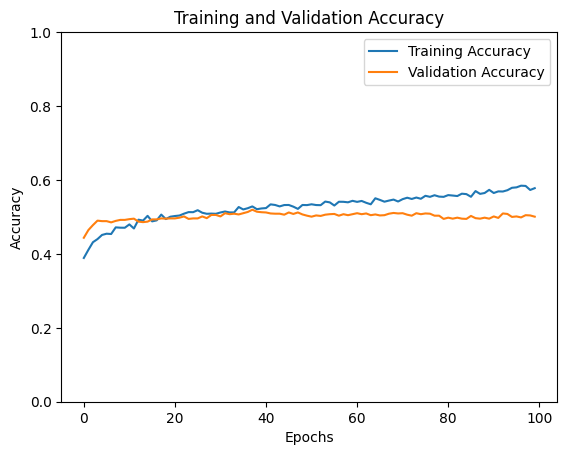

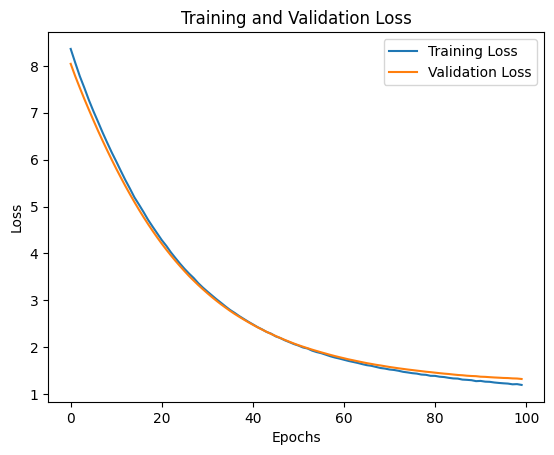

Test Accuracy: 0.51
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Confusion Matrix:
[[283 101 187]
 [124  72 257]
 [149 100 589]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5090    0.4956    0.5022       571
           1     0.2637    0.1589    0.1983       453
           2     0.5702    0.7029    0.6296       838

    accuracy                         0.5070      1862
   macro avg     0.4476    0.4525    0.4434      1862
weighted avg     0.4769    0.5070    0.4856      1862



In [23]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y.shape[1]),
    y=np.argmax(y, axis=1)
)
class_weights = dict(enumerate(class_weights))

def compute_dnn():
    # Define the DNN model
    model = Sequential([
        Dense(512, kernel_regularizer=l2(0.01)),  # Add L2 regularization
        BatchNormalization(),  # Batch Normalization
        LeakyReLU(alpha=0.1),  # Leaky ReLU activation
        Dropout(0.5),

        Dense(256, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(128, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Visualize training and validation log loss and accuracy

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()

    # Visualize training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Generate predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities and true labels into class indices
    y_pred_original = np.argmax(y_pred, axis=1)
    y_test_original = np.argmax(y_test, axis=1)

    # Display confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_original, y_pred_original))

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_original, digits=4))

compute_dnn()

#### K-Means


Classification Report:
              precision    recall  f1-score   support

        Away     0.3561    0.5247    0.4242       547
        Draw     0.2578    0.3579    0.2997       461
        Home     0.6611    0.3220    0.4331       854

    accuracy                         0.3904      1862
   macro avg     0.4250    0.4015    0.3857      1862
weighted avg     0.4716    0.3904    0.3975      1862

Visualizing Clusters...


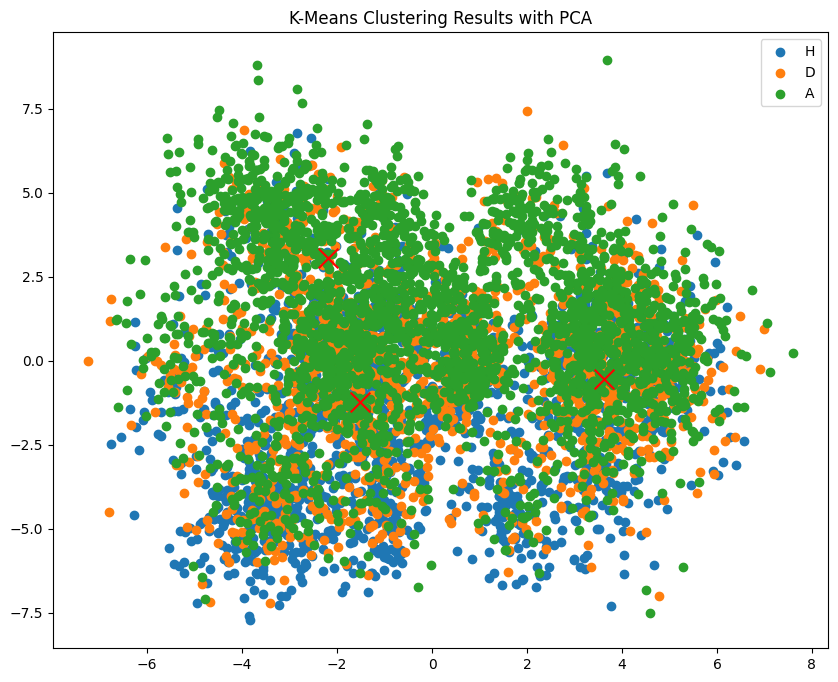

In [24]:
# Scatter Plot of the Clusters with PCA  
def plot_clusters(X, y_pred, kmeans):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    for cluster in np.unique(y_pred):
        cluster_points = X_pca[y_pred == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot centroids
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')

    plt.title("K-Means Clustering Results with PCA")
    
    plt.legend(["H", "D", "A"])
    plt.show()

# Evaluate Performance
def evaluate_performance(X, y_true, y_pred, kmeans):
    print("Visualizing Clusters...")
    plot_clusters(X, y_pred, kmeans)
    
def compute_knn():

    y_single = y.idxmax(axis=1).map({'FTR_A': 'Away', 'FTR_D': 'Draw', 'FTR_H': 'Home'})
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_single)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_encoded
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )

    # Initialize K-Means with number of clusters equal to the number of unique classes
    n_clusters = len(le.classes_) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    cluster_labels = kmeans.labels_

    cont_matrix = confusion_matrix(y_train, cluster_labels)
    # Apply the Hungarian algorithm to find the optimal mapping
    row_ind, col_ind = linear_sum_assignment(-cont_matrix)
    cluster_to_label = {}
    for cluster, label in zip(col_ind, row_ind):
        cluster_to_label[cluster] = label

    test_cluster_labels = kmeans.predict(X_test)
    # Map cluster labels to actual labels using the optimal cluster_to_label mapping
    test_predicted_labels = pd.Series(test_cluster_labels).map(cluster_to_label)
    test_predicted_labels = test_predicted_labels.fillna(-1).astype(int)
    predicted_labels_original = np.empty_like(test_predicted_labels, dtype=object)

    # Identify valid predictions (clusters that were mapped)
    valid_indices = test_predicted_labels != -1

    # Inverse transform only valid predictions
    predicted_labels_original[valid_indices] = le.inverse_transform(test_predicted_labels[valid_indices])

    # Assign a placeholder for invalid predictions
    predicted_labels_original[~valid_indices] = "Unknown"

    # Inverse transform true labels for evaluation
    y_test_original = le.inverse_transform(y_test)

    print("\nClassification Report:")
    print(classification_report(
        y_test_original[valid_indices],
        predicted_labels_original[valid_indices],
        zero_division=0,
        digits=4
    ))

    evaluate_performance(X_train, y_test, y_train, kmeans)

compute_knn()

#### Support Vector Machine (SVM)

In [25]:
def compute_svm():
    y_single = y.idxmax(axis=1).map({'FTR_A': 'Away', 'FTR_D': 'Draw', 'FTR_H': 'Home'})

    # Initialize LabelEncoder
    le = LabelEncoder()

    # Fit and transform the single labels
    y_encoded = le.fit_transform(y_single)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

    # Train SVM model
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_, digits=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display performance
    print("Classification Report:\n", report)

compute_svm()

Classification Report:
               precision    recall  f1-score   support

        Away     0.5156    0.4597    0.4861       683
        Draw     0.3333    0.0468    0.0821       577
        Home     0.5372    0.8240    0.6504      1068

    accuracy                         0.5245      2328
   macro avg     0.4621    0.4435    0.4062      2328
weighted avg     0.4804    0.5245    0.4613      2328



### 5.2 Chosen Approach - Gradient Boosted Decision Tree

In [26]:
# Map one-hot encoded labels to single integer labels
label_mapping = {'FTR_A': 0, 'FTR_D': 1, 'FTR_H': 2}

def one_hot_to_single(y):
    return y.idxmax(axis=1).map(label_mapping)

# Convert one-hot encoded labels
y_train_single = one_hot_to_single(y_train)
y_val_single = one_hot_to_single(y_val)
y_test_single = one_hot_to_single(y_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_single),
    y=y_train_single
)

# Map class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# Assign sample weights for training
sample_weights = np.array([class_weight_dict[label] for label in y_train_single])

# Initialize the XGBClassifier with specified hyperparameters
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric=['mlogloss', 'merror'],
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.001,
    n_estimators=100,
    max_depth=4,
    min_child_weight=5,
    gamma=0.5,
    reg_alpha=2.0,
    reg_lambda=15.0,
    booster='dart',
    sample_type='uniform',
    normalize_type='tree',
    rate_drop=0.1,
    skip_drop=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    grow_policy='lossguide',
    max_leaves=32
)

# Train the classifier
xgb_clf.fit(
    X_train,
    y_train_single,
    eval_set=[(X_train, y_train_single), (X_val, y_val_single)],
    verbose=True
)

Class weights: {0: 1.1517788089713843, 1: 1.3453026196928637, 2: 0.7202273002055374}
[0]	validation_0-mlogloss:1.09842	validation_0-merror:0.45946	validation_1-mlogloss:1.09845	validation_1-merror:0.49060
[1]	validation_0-mlogloss:1.09823	validation_0-merror:0.45745	validation_1-mlogloss:1.09830	validation_1-merror:0.49396
[2]	validation_0-mlogloss:1.09805	validation_0-merror:0.45577	validation_1-mlogloss:1.09815	validation_1-merror:0.48993
[3]	validation_0-mlogloss:1.09787	validation_0-merror:0.45509	validation_1-mlogloss:1.09800	validation_1-merror:0.49060
[4]	validation_0-mlogloss:1.09777	validation_0-merror:0.45627	validation_1-mlogloss:1.09793	validation_1-merror:0.49396
[5]	validation_0-mlogloss:1.09768	validation_0-merror:0.45627	validation_1-mlogloss:1.09785	validation_1-merror:0.49262


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:12:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-mlogloss:1.09762	validation_0-merror:0.45526	validation_1-mlogloss:1.09780	validation_1-merror:0.49262
[7]	validation_0-mlogloss:1.09744	validation_0-merror:0.45728	validation_1-mlogloss:1.09766	validation_1-merror:0.49128
[8]	validation_0-mlogloss:1.09738	validation_0-merror:0.45610	validation_1-mlogloss:1.09761	validation_1-merror:0.48993
[9]	validation_0-mlogloss:1.09719	validation_0-merror:0.45694	validation_1-mlogloss:1.09745	validation_1-merror:0.48859
[10]	validation_0-mlogloss:1.09710	validation_0-merror:0.45711	validation_1-mlogloss:1.09738	validation_1-merror:0.48792
[11]	validation_0-mlogloss:1.09692	validation_0-merror:0.45593	validation_1-mlogloss:1.09722	validation_1-merror:0.48725
[12]	validation_0-mlogloss:1.09687	validation_0-merror:0.45745	validation_1-mlogloss:1.09718	validation_1-merror:0.48591
[13]	validation_0-mlogloss:1.09684	validation_0-merror:0.45711	validation_1-mlogloss:1.09715	validation_1-merror:0.48591
[14]	validation_0-mlogloss:1.09681	v

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss', 'merror'], feature_types=None, gamma=0.5,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=32,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              normalize_type='tree', num_class=3, ...)

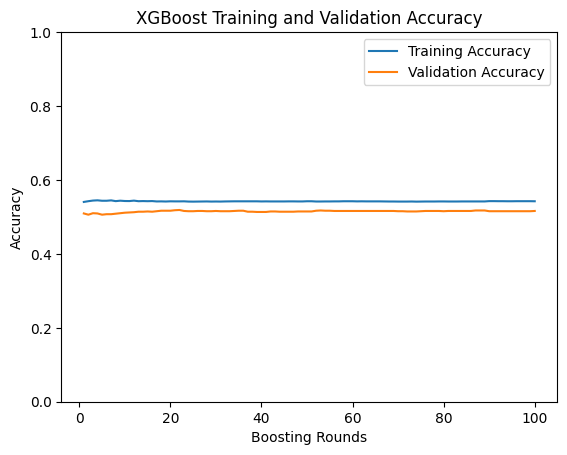

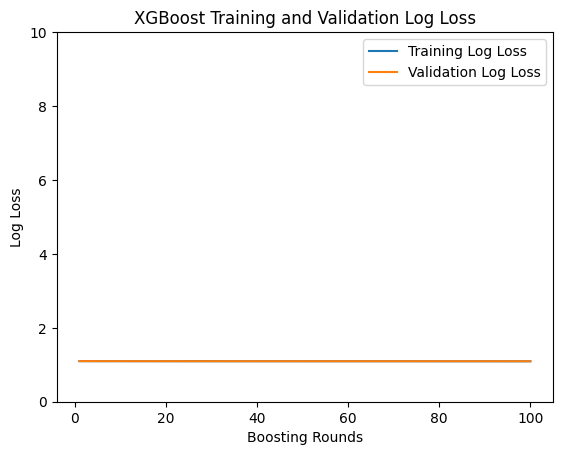

In [27]:
# Retrieve evaluation results
evals_result = xgb_clf.evals_result()

# Extract log loss for training and validation sets
train_logloss = evals_result['validation_0']['mlogloss']
val_logloss = evals_result['validation_1']['mlogloss']

# Extract error rates and convert to accuracy
train_merror = evals_result['validation_0']['merror']
val_merror = evals_result['validation_1']['merror']

train_accuracy = [1 - error for error in train_merror]
val_accuracy = [1 - error for error in val_merror]

# Determine the number of boosting rounds
num_rounds = len(train_logloss)

plt.plot(range(1, num_rounds + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_rounds + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(range(1, num_rounds + 1), train_logloss, label='Training Log Loss')
plt.plot(range(1, num_rounds + 1), val_logloss, label='Validation Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.ylim(0, 10)
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()
plt.show()

XGBoost Test Accuracy: 0.53

XGBoost Classification Report:
                  precision    recall  f1-score   support

FTR_A (Away Win)     0.5570    0.4361    0.4892       571
    FTR_D (Draw)     0.0000    0.0000    0.0000       453
FTR_H (Home Win)     0.5173    0.8735    0.6498       838

        accuracy                         0.5269      1862
       macro avg     0.3581    0.4365    0.3797      1862
    weighted avg     0.4036    0.5269    0.4425      1862


XGBoost Confusion Matrix:
[[249   0 322]
 [ 92   0 361]
 [106   0 732]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

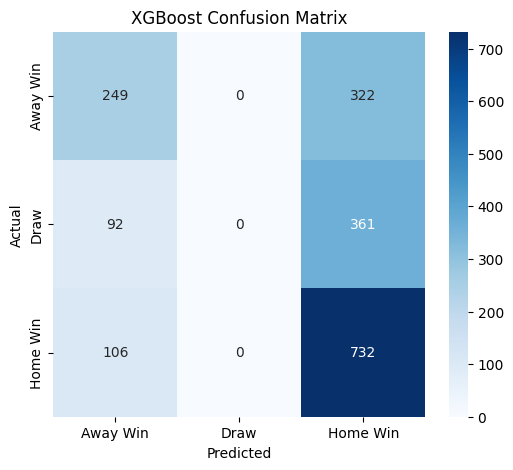

In [28]:
# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate test accuracy
test_accuracy_xgb = accuracy_score(y_test_single, y_pred_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")

# Generate classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test_single, y_pred_xgb, target_names=['FTR_A (Away Win)', 'FTR_D (Draw)', 'FTR_H (Home Win)'], digits=4))

# Generate confusion matrix
print("\nXGBoost Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_single, y_pred_xgb)
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

### 6. Results

### 7. Final Predictions on Test Set

In [30]:
# Load and preprocess test data
epl_test = pd.read_csv('../data/epl-test.csv')

# Replace team names
team_replacements = {
    'AFC Bournemouth': 'Bournemouth',
    'Spurs': 'Tottenham',
    'Leicester City': 'Leicester',
    'Ipswich Town': 'Ipswich',
    'Man Utd': 'Man United',
    'Nottingham Forest': 'Nott’m Forest'
}
epl_test['HomeTeam'] = epl_test['HomeTeam'].replace(team_replacements)
epl_test['AwayTeam'] = epl_test['AwayTeam'].replace(team_replacements)

# Fix month presentation and two-digit years and convert dates to datetime
epl_test['Date'] = epl_test['Date'].str.replace('Feb', '02', regex=False)
epl_test['Date'] = epl_test['Date'].apply(lambda x: f"{x[:-2]}20{x[-2:]}")
epl_test['Date'] = pd.to_datetime(epl_test['Date'], format='%d-%m-%Y')

# Load additional data for calculations
loaded = load_and_prepare_data()

# Create a copy of the DataFrame and drop unnecessary columns
df_copy_2 = df.copy()
df_copy_2 = df_copy_2.drop(columns=[
    'H14', 'A14', 'Attendance', 'HTV($m)', 'ATV($m)',
    'HTPos_avg', 'ATPos_avg', 'HSPE (%)', 'HPE (%)', 'ASPE (%)', 'APE (%)'
])

# Add missing columns to epl_test
for col in df_copy_2.columns:
    if col not in epl_test.columns:
        epl_test[col] = np.nan

# Combine training and test data
combined = pd.concat([df_copy_2, epl_test], ignore_index=True)

# Recalculate 14-day density
combined = calculate_14_day_density(combined, loaded)

# Calculate additional features on combined data
combined = calculate_standings(combined)
combined = compute_team_features(combined)
combined = main_workflow(combined, alterations)

# Format the 'Date' column
combined['Date'] = combined['Date'].dt.strftime('%d/%m/%Y')

/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/19081304.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epl_test[col] = np.nan
/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/19081304.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  epl_test[col] = np.nan
/var/folders/rb/p7y6drds39702zht2np4cgk80000gn/T/ipykernel_59509/19081304.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [34]:
# Extract the last 10 rows of the combined DataFrame
epl_test = combined.tail(10).reset_index(drop=True)

# Drop specified columns and those starting with 'HomeTeam_' or 'AwayTeam_'
columns_to_drop = ['Day', 'Month', 'Year', 'DayOfWeek']
columns_to_drop += [col for col in combined.columns if col.startswith('HomeTeam_') or col.startswith('AwayTeam_')]
epl_test = epl_test.drop(columns=columns_to_drop, errors='ignore')

# Create dummy variables and add them to the DataFrame
dummies = pd.get_dummies(
    epl_test[['FTR', 'HomeTeam', 'AwayTeam']],
    prefix=['FTR', 'HomeTeam', 'AwayTeam']
)
epl_test = pd.concat([epl_test, dummies], axis=1)

# Create a copy of epl_test and drop unnecessary columns
epl_test_copy = epl_test.copy()
columns_to_remove = [
    'Winner', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'
]
epl_test_copy.drop(columns=columns_to_remove, inplace=True)

# Process date-related columns
epl_test_copy = process_date_columns(epl_test_copy)

# Drop additional columns
epl_test_copy.drop(columns=['Date', 'HomeTeam', 'AwayTeam', 'Attendance'], inplace=True)

# Preview the final DataFrame
epl_test_copy

,Day,Month,Year,DayOfWeek,Strictness,Season,Round,Hpts,Apts,HTS,ATS,HGSR,AGSR,Home_DS,Away_DS,Home_Form_Points,Away_Form_Points,Home_Goal_Diff_Form,Away_Goal_Diff_Form,Home_Win_Streak,Away_Win_Streak,Home_H2H_Win_Rate,Away_H2H_Win_Rate,HTPos_avg_missing,ATPos_avg_missing,HSPE_missing,ASPE_missing,HPE_missing,APE_missing,HTV_missing,ATV_missing,Home_Rolling_Points,Away_Rolling_Points,Home_Rolling_Possession,Away_Rolling_Possession,FTR_A,FTR_D,FTR_H,H14,A14,HTV($m),ATV($m),HTPos_avg,ATPos_avg,HSPE (%),HPE (%),ASPE (%),APE (%),FTR_A,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brentford,HomeTeam_Chelsea,HomeTeam_Everton,HomeTeam_Ipswich,HomeTeam_Man United,HomeTeam_Newcastle,HomeTeam_Nott’m Forest,HomeTeam_Wolves,AwayTeam_Aston Villa,AwayTeam_Brighton,AwayTeam_Crystal Palace,AwayTeam_Fulham,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Southampton,AwayTeam_Tottenham,AwayTeam_West Ham
0,1,2,2025,6,NaN,2024,19,6,23,1.150877,1.919355,1.266667,1.851613,1.722807,0.981720,1.4,2.5,-4.0,11.0,3,2,0.133333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,354.85,931.00,0.443,0.572,0.327661,-0.215811,-1.555893,0.488948,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,1,2,2025,6,NaN,2024,20,24,15,1.949517,1.848824,1.909774,1.903695,1.036520,1.051512,2.4,1.9,14.0,12.0,3,1,0.212766,0.148936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,1170.00,1260.00,0.502,0.639,-0.017042,-1.860250,-0.604603,-0.739042,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,1,2,2025,6,NaN,2024,20,6,16,1.263158,1.632653,1.466165,1.619764,1.518797,1.249194,1.8,1.7,3.0,4.0,1,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,403.03,788.30,0.471,0.615,-0.604603,0.382166,-0.509474,-1.860250,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,1,2,2025,6,NaN,2024,20,13,10,1.940924,1.236230,1.816327,1.264382,0.955961,1.498164,1.3,1.0,5.0,-5.0,1,1,0.348837,0.046512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,963.20,481.50,0.545,0.455,-1.032684,-0.685651,-1.686696,2.250846,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,2,2025,6,NaN,2024,20,9,5,1.389247,1.267368,1.280645,1.381053,1.280645,1.477895,1.0,1.1,-4.0,0.0,0,1,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,353.10,275.60,0.393,0.477,1.792648,-1.860250,0.536945,-0.098352,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,1,2,2025,6,NaN,2024,20,3,5,1.231579,1.172249,1.221053,1.189793,1.463158,1.459330,1.3,0.9,-7.0,-4.0,1,0,0.200000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,195.40,283.20,0.408,0.566,-0.771079,-1.860250,-1.032684,-1.860250,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,1,2,2025,6,NaN,2024,20,16,10,1.992481,1.160000,1.823845,1.147368,0.976369,1.429474,1.9,1.5,6.0,1.0,0,0,0.320000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,854.15,438.00,0.522,0.456,1.393106,0.382166,3.676202,1.663546,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
7,1,2,2025,6,NaN,2024,20,12,2,1.328655,1.154887,1.319298,1.156391,1.422222,1.458647,1.3,0.8,1.0,-4.0,1,0,0.242424,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,657.65,346.00,0.490,0.535,-0.911943,0.037179,-2.602312,-0.318589,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
8,1,2,2025,6,NaN,2024,20,0,11,0.000000,1.214035,0.00

In [42]:
# Load and preprocess test data
epl_test = pd.read_csv('../data/epl-test.csv')

# Add missing columns to epl_test_copy and initialize with zeros
for col in training_features:
    if col not in epl_test_copy.columns:
        epl_test_copy[col] = 0

# Align epl_test_copy to match the training feature set
X_test = epl_test_copy[training_features]

# Predict match outcomes using the trained model
predictions = xgb_clf.predict(X_test)

# Map predictions to their corresponding match results
outcome_map = {0: 'A', 1: 'D', 2: 'H'}
epl_test_copy['Predicted_FTR'] = [outcome_map[pred] for pred in predictions]

# Combine test match details with predicted results
result = pd.concat(
    [epl_test[['Date', 'HomeTeam', 'AwayTeam']], epl_test_copy[['Predicted_FTR']]], 
    axis=1
)

# Display the predictions
print(result)

# Save the predictions to a CSV file
result.to_csv('../data/predictions.csv', index=False)

        Date           HomeTeam        AwayTeam Predicted_FTR
0  01-Feb-25    AFC Bournemouth       Liverpool             H
1  01-Feb-25            Arsenal        Man City             H
2  01-Feb-25          Brentford           Spurs             H
3  01-Feb-25            Chelsea        West Ham             H
4  01-Feb-25            Everton  Leicester City             H
5  01-Feb-25       Ipswich Town     Southampton             H
6  01-Feb-25            Man Utd  Crystal Palace             H
7  01-Feb-25          Newcastle          Fulham             H
8  01-Feb-25  Nottingham Forest        Brighton             A
9  01-Feb-25             Wolves     Aston Villa             H
